This Jupyter notebook was created and run in Google Collaboratory. It contains the data pre-processing, cleaning, and Vega-lite visualizations and specifications. Raj handled Task 1, Abdullah and Neil handled Task 2, and Andy handled Task 3. The first few visualizations in Task 1 took a significant amount of time, probably a couple hours, simply because of getting familiar with the new Vega-Lite syntax and figuring out how to display them in Colab. The Task 2 interactive visualizations also took some time, but the examples in the documentation helped.

In [44]:
!pip install -q sodapy
!pip install -q jupyter pandas vega3
!pip install --upgrade notebook -q
!jupyter nbextension install --sys-prefix --py vega3
!jupyter nbextension install --sys-prefix --py vega
!jupyter nbextension enable --py --sys-prefix vega


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab labextension labhub
migrate nbclassic nbconvert notebook qtconsole run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--jso

In [45]:
!pip install altair_viewer -q
!pip install wordcloud -q
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [46]:
from vega3 import VegaLite
import numpy as np
import pandas as pd
import geopandas as gpd
from sodapy import Socrata
import IPython
import altair as alt
from IPython.display import display

client = Socrata("data.cityofchicago.org", None)
results = client.get("ygr5-vcbg", limit=5000) # Connect to Chicago data API to fetch data

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
print("Total rows: "+ str(len(dfOriginal)))
dfOriginal.head()

Total rows: 3121


,tow_date,make,style,color,plate,state,towed_to_address,tow_facility_phone,inventory_number,model
0,2023-11-03T00:00:00.000,ACUR,4D,BLK,LN15622,IL,10300 S. Doty,(773) 568-8495,2958660,NaN
1,2023-11-03T00:00:00.000,ACUR,4D,BLK,EC76271,IL,701 N. Sacramento,(773) 265-7605,7072808,NaN
2,2023-11-03T00:00:00.000,ACUR,LL,WHI,BF79582,IL,701 N. Sacramento,(773) 265-7605,7072831,NaN
3,2023-11-03T00:00:00.000,BMW,4D,BLK,CM24444,IL,701 N. Sacramento,(773) 265-7605,7072819,NaN
4,2023-11-03T00:00:00.000,BUIC,4D,RED,DX78993,IL,701 N. Sacramento,(773) 265-7605,7072817,NaN


# Data Cleaning

In [47]:
dff = dfOriginal.drop('model', axis=1) # Drop model column since a very large proportion of the data doesn't have one
dff.dropna(inplace=True) # Drop any remaining rows with missing data

df = dff
df['tow_date'] = pd.to_datetime(df['tow_date']) # convert tow_date to datetime object
print("Total rows: "+ str(len(df)))
df.head()


Total rows: 2414


,tow_date,make,style,color,plate,state,towed_to_address,tow_facility_phone,inventory_number
0,2023-11-03,ACUR,4D,BLK,LN15622,IL,10300 S. Doty,(773) 568-8495,2958660
1,2023-11-03,ACUR,4D,BLK,EC76271,IL,701 N. Sacramento,(773) 265-7605,7072808
2,2023-11-03,ACUR,LL,WHI,BF79582,IL,701 N. Sacramento,(773) 265-7605,7072831
3,2023-11-03,BMW,4D,BLK,CM24444,IL,701 N. Sacramento,(773) 265-7605,7072819
4,2023-11-03,BUIC,4D,RED,DX78993,IL,701 N. Sacramento,(773) 265-7605,7072817


# **Task 1**

# Donut chart of total vehicles towed from each state (by license plate)
This chart visualizes the total amount of vehicles towed in Chicago from their state of origin, as per the recorded license plate on the vehicle. The counts of each slice are available in the tooltip.

In [48]:
state_counts = df['state'].value_counts() # make a count of all the state plates
state_keep = state_counts[state_counts >= 10].index # specify that we are keeping only states that have 10 vehicles and over, to reduce visualization cluttering
df_states = df[df['state'].isin(state_keep)] # creates a new dataframe with states that have a count of 10 and over

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Donut chart of total vehicles towed from each state (by license plate)",
  "data": {
    "values": df_states.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "width": 500,
  # "data": {"url": "https://data.cityofchicago.org/resource/ygr5-vcbg.json"},
  "mark": {"type": "arc", "innerRadius": 50, "tooltip": True},
  "encoding": {
    "theta": {"aggregate": "count"},
    "color": {"type": "nominal","field": "state"}
  }
}


display(alt.display.html_renderer(spec), raw=True)

# Point plot of vehicles towed over time (past 3 months as per data)
This point plot shows the number of vehicles towed every day in the 3 months available from the dataset.

In [49]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Point plot of vehicles towed over time",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "width": 1000,
  "mark": {"type": "point", "tooltip": True},
  "encoding": {
    "x": {"field": "tow_date", "type": "temporal"},
    "y": {"aggregate": "count", "stack": "quantitative",
      "axis": {
        "title": "Vehicles Towed"
      }
    }
  }
}


display(alt.display.html_renderer(spec), raw=True)

# Pie chart of total vehicles towed by make
This pie chart shows the most common makes towed in Chicago and their relative amount. Counts of each slice are available in the tooltip.

In [50]:
make_counts = df['make'].value_counts() # make a count of all the makes
make_keep = make_counts[make_counts >= 40].index # specify that we are keeping only makes that have 40 vehicles and over, to reduce visualization cluttering
df_makes = df[df['make'].isin(make_keep)] # creates a new dataframe with makes that have a count of 40 and over

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Pie chart of total vehicles towed by make",
  "data": {
    "values": df_makes.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "width": 500,
  "mark": {"type": "arc", "tooltip": True},
  "encoding": {
    "theta": {"aggregate": "count", "stack": "normalize"},
    "color": {"field": "make", "type": "nominal"}
  }
}


display(alt.display.html_renderer(spec), raw=True)

# Multiline chart of vehicles towed over time to each impound lot
This multiline chart shows the total number of vehicles towed to each different impound lot on each different day present in the dataset.

In [51]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Multiline chart of vehicles towed over time to each lot",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "width": 1000,
  "mark": {"type": "line", "tooltip": True},
  "encoding": {
    "x": {"field": "tow_date", "type": "temporal"},
    "y": {"aggregate": "count", "stack": "quantitative",
      "axis": {
        "title": "Vehicles Towed"
      }
    },
    "color": {"field": "towed_to_address", "type": "nominal"}
  }
}


display(alt.display.html_renderer(spec), raw=True)

# Heat map of vehicled towed to each impound lot from each state
This heat map shows which impound lot the vehicles towed from each state in Chicago (as per their license plate) tend to end up.

In [52]:
# state_counts = df['state'].value_counts() # make a count of all the state plates
# state_keep = state_counts[state_counts >= 10].index # specify that we are keeping only states that have 10 vehicles and over, to reduce visualization cluttering
# df_states = df[df['state'].isin(state_keep)] # creates a new dataframe with states that have a count of 10 and over

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "title": "Heat map of vehicled towed to each lot from each state",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "mark": {"type": "rect", "tooltip": True},
  "encoding": {
    "x": {"type": "nominal","field": "state"},
    "y": {"field": "towed_to_address", "type": "nominal"},
    "color": {"aggregate": "count"}
  },
  "config": {
    "axis": {"grid": True, "tickBand": "extent"}
  }
}


display(alt.display.html_renderer(spec), raw=True)

# Horizontally concancenated bar charts showing makes towed to two different impound lots
These two bar charts show two popular impound lots, and the top 10 most common makes that are towed to each lot. Makes were limited to the top 10 for visibility purposes.

In [53]:
make_counts = df['make'].value_counts() # make a count of all the makes
make_keep = make_counts[make_counts >= 60].index # specify that we are keeping only makes that have 60 vehicles and over, to reduce visualization cluttering
df_makes = df[df['make'].isin(make_keep)] # creates a new dataframe with makes that have a count of 60 and over

spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": df_makes.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "hconcat": [
    {
      "transform": [{"filter": "datum.towed_to_address == '10300 S. Doty'"}],
      "width": 500,
      "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {"type": "nominal","field": "make"},
        "x": {"aggregate": "count",
          "axis": {
            "title": "Vehicles Towed to 10300 S. Doty"
          }
        }
      }
    },
    {
      "transform": [{"filter": "datum.towed_to_address == '701 N. Sacramento'"}],
      "width": 500,
      "mark": {"type": "bar", "tooltip": True},
      "encoding": {
        "y": {"type": "nominal","field": "make"},
        "x": {"aggregate": "count",
          "axis": {
            "title": "Vehicles Towed to 701 N. Sacramento"
          }
        }
      }
    }
  ]
}


display(alt.display.html_renderer(spec), raw=True)

# **Task 2**

Multi-area chart showing temporal trends (grouped by address of impound lot) and a bar chart displaying the count of vehicles towed to specific addresses. Clicking and dragging to make a selection on the area chart changes the counts displayed in the bar chart.

In [54]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "resolve": {"scale": {"y": "independent"}},
  "config": {"view": {"continuousWidth": 400, "continuousHeight": 300}},
  "hconcat": [
    {
      "mark": {"type": "area", "line": True, "point": True},
      "encoding": {
        "color": {"field": "towed_to_address", "type": "nominal"},
        "tooltip": {"aggregate": "count", "type": "quantitative"},
        "x": {"field": "tow_date", "timeUnit": "yearmonth", "type": "temporal"},
        "y": {"aggregate": "count", "type": "quantitative"}
      },
      "height": 200,
      "selection": {"selector005": {"type": "interval", "encodings": ["x"]}},
      "width": 400
    },
    {
      "mark": "bar",
      "encoding": {
        "color": {"field": "towed_to_address", "type": "nominal"},
        "x": {"field": "towed_to_address", "type": "nominal"},
        "y": {"aggregate": "count", "type": "quantitative"}
      },
      "height": 200,
      "transform": [{"filter": {"selection": "selector005"}}],
      "width": 200
    }
  ]
}


display(alt.display.html_renderer(spec), raw=True)

# Interactive chart of towed vehicles by color and make
This point chart shows the various colors present for all the towed vehicle makes. Clicking and dragging to make a selection on the point chart shows the total number of those colors in the bar chart.

In [55]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "config": {"view": {"continuousWidth": 400, "continuousHeight": 300}},
  "hconcat": [
    {
      "mark": "circle",
      "encoding": {
        "color": {"field": "make", "type": "nominal"},
        "x": {"field": "color", "type": "nominal"},
        "y": {"field": "make", "type": "nominal"}
      },
      "height": 750,
      "selection": {"selector002": {"type": "interval"}},
      "width": 500
    },
    {
      "mark": "bar",
      "encoding": {
        "color": {"field": "color", "type": "nominal"},
        "x": {"aggregate": "count", "type": "quantitative"},
        "y": {"field": "color", "type": "nominal"}
      },
      "height": 500,
      "transform": [{"filter": {"selection": "selector002"}}],
      "width": 500
    }
  ]
}

display(alt.display.html_renderer(spec), raw=True)

# Interactive bar charts showing vehicles towed by month and then make
These are interactive bar charts of the 'Date Distribution' and 'Car Make Distribution' charts. They ensure interactivity by adding a selection tool (brush) that filters the 'Car Make Distribution' chart based on the selection made in the 'Date Distribution' chart. Brushing over the 'Date Distribution' chart will dynamically filter the 'Car Make Distribution' chart accordingly.

In [56]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "config": {"view": {"continuousWidth": 400, "continuousHeight": 300}},
  "hconcat": [
    {
      "mark": "bar",
      "encoding": {
        "x": {"field": "tow_date", "timeUnit": "yearmonth", "type": "ordinal"},
        "y": {"aggregate": "count", "type": "quantitative"}
      },
      "height": 200,
      "selection": {"selector003": {"type": "interval", "encodings": ["x"]}},
      "transform": [{"filter": {"selection": "selector003"}}],
      "width": 400
    },
    {
      "mark": "bar",
      "encoding": {
        "x": {"field": "make", "type": "nominal"},
        "y": {"aggregate": "count", "type": "quantitative"}
      },
      "height": 200,
      "transform": [{"filter": {"selection": "selector003"}}],
      "width": 1000
    }
  ]
}

display(alt.display.html_renderer(spec), raw=True)

# Interactive stacked bar chart of Tow Date vs Number of Vehicles Towed by Towed To Address
These two stacked bar charts show how many vehicles were towed to each impound lot every day. Clicking and dragging to make a selection on the first stacked bar chart restricts the view to just those dates in the second stacked bar chart.

In [57]:
# Chart 1: Tow Date vs Number of Vehicles Towed by Towed To Address
chart1 = {
    "data": {
        "values": df.to_csv(index=False),
        "format": {"type": "csv"}
    },
    "width": 1000,
    "height": 300,
    "mark": "bar",
    "selection": {
        "brush": {"type": "interval", "encodings": ["x"]}
    },
    "encoding": {
        "x": {"field": "tow_date", "type": "temporal", "title": "Tow Date"},
        "y": {"aggregate": "count", "type": "quantitative", "title": "Vehicles Towed"},
        "color": {"field": "towed_to_address", "type": "nominal"}
    }
}

# Chart 2: Detail View for Selection
chart2 = {
    "data": {
        "values": df.to_csv(index=False),
        "format": {"type": "csv"}
    },
    "width": 1000,
    "height": 300,
    "mark": "bar",
    "encoding": {
        "x": {"field": "tow_date", "type": "temporal", "title": "Tow Date"},
        "y": {"aggregate": "count", "type": "quantitative", "title": "Vehicles Towed"},
        "color": {"field": "towed_to_address", "type": "nominal"},
        "tooltip": [{"field": "tow_date", "type": "temporal", "title": "Tow Date"}, {"field": "towed_to_address", "type": "nominal", "title": "Towed To Address"}]
    },
    "transform": [{"filter": {"selection": "brush"}}]
}

# Display Charts
alt.vconcat(alt.Chart.from_dict(chart1), alt.Chart.from_dict(chart2))


alt.VConcatChart(...)

# **Task 3**

This spatial visualization shows where cars were towed to via a bar chart, total vehicles towed are aggregated and then split up between the four spatial data points present in the dataset (impound lot).

In [58]:
spec = {
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {
    "values": df.to_csv(),
    "format": {
      "type": "csv"
    }
  },
  "width": 300,
  "mark": {"type": "bar", "tooltip": True},
  "encoding": {
    "x": {"type": "nominal","field": "towed_to_address"},
    "y": {"aggregate": "count", "field": "make", "type": "nominal"}
  }
}


display(alt.display.html_renderer(spec), raw=True)

# **Task 4**
### Here's wordCloud of frequency of the car makes from our sketches in assignment 1 that we could not implement using vegalite.

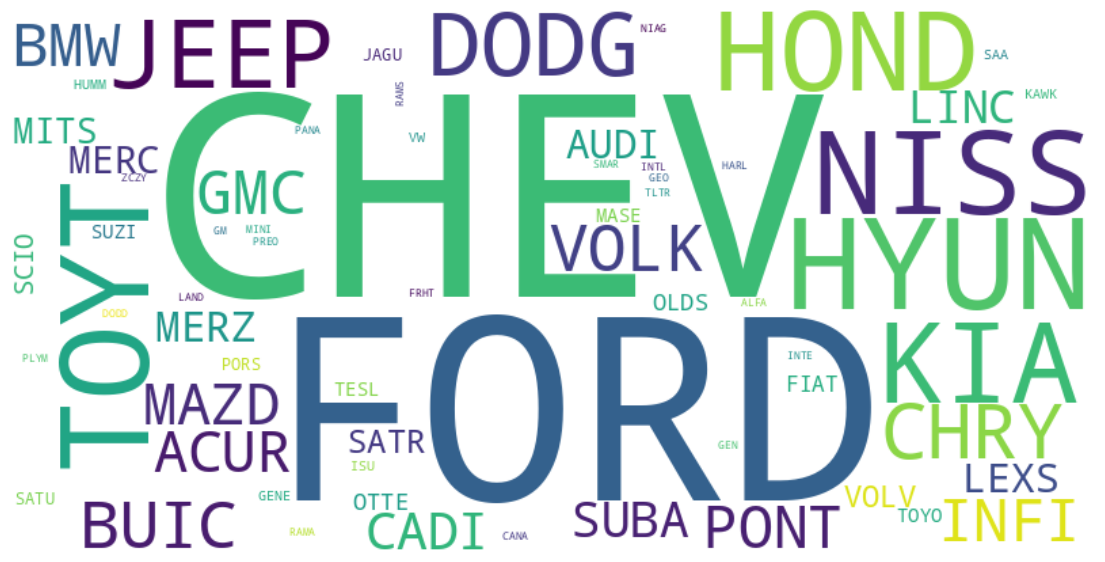

In [59]:
# Extracting car makes and their frequencies
car_make_counts = df['make'].value_counts().to_dict()

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False,).generate_from_frequencies(car_make_counts)

# Display the word cloud using matplotlib
plt.figure(figsize=(14, 11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
